# Metrolyrics Text Classification

## Text Classification
In this section, you'll build a text classifier, determining the genre of a song based on its lyrics.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

# from sklearn import metrics
# from sklearn.model_selection import train_test_split
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE

# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.ensemble import ExtraTreesClassifier

In [2]:
df = pd.read_parquet('lyrics.parquet')

### Text classification using Bag-of-Words
Build a Naive Bayes classifier based on the bag of Words.  
You will need to divide your dataset into a train and test sets.

Our dataset is pretty large, and keeping 10% for test still gives us 1,000 songs for each category.  
I would even consider a small percentage of test set, if I have reasons to believe more data would greatly improve the classifier performance.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

X_train, X_test, y_train, y_test = \
  train_test_split(df.sent, df.genre, test_size=0.1, random_state=0) # We used 10,000 songs from each category - 1,000 songs in the test set seem like a lot. 

X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)

Note that the count vectorizer is only fitted on the train set. It's very easy to allow a leakage in these cases.  
The safest way to avoid them is using pipelines, but here we'll focus on regular flow.

In [4]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

model = MultinomialNB(alpha=1)
model.fit(X_train_counts, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

nb = MultinomialNB(alpha=1)
count_vect = CountVectorizer(stop_words='english')
nb_pipe = make_pipeline(count_vect, nb)
nb_pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('multinomialnb', MultinomialNB(alpha=1, class_prior=None, fit_prior=True))])

Show the confusion matrix.

Note below that when Y values are the names of the classes as strings, the report includes them and is much easier to interpret.

In [6]:
genres = sorted(df.genre.unique())

In [7]:
# Predict
print('Performance on the train set:')
y_pred = model.predict(X_train_counts)
cm = confusion_matrix(y_train, y_pred)
print( pd.DataFrame(cm, index=genres, columns=genres) )

print('\nPerformance on the test set:')
y_pred = model.predict(X_test_counts)
cm = confusion_matrix(y_test, y_pred)
print( pd.DataFrame(cm, index=genres, columns=genres) )

Performance on the train set:
         Country  Hip-Hop  Metal   Pop  Rock
Country     6485       57    135   259   525
Hip-Hop      261     7083    173   814   486
Metal        213      265   6468   290  1185
Pop         2104      607    429  4126  2461
Rock        2047      408    899   785  6413

Performance on the test set:
         Country  Hip-Hop  Metal  Pop  Rock
Country      664       10     15   34    90
Hip-Hop       31      729     22   83    48
Metal         34       39    747   36   162
Pop          253       92     48  357   323
Rock         278       89    129  118   567


Show the classification report - precision, recall, f1 for each class.

In [8]:
y_pred = model.predict(X_test_counts)
print( classification_report(y_test, y_pred ))

             precision    recall  f1-score   support

    Country       0.53      0.82      0.64       813
    Hip-Hop       0.76      0.80      0.78       913
      Metal       0.78      0.73      0.75      1018
        Pop       0.57      0.33      0.42      1073
       Rock       0.48      0.48      0.48      1181

avg / total       0.62      0.61      0.60      4998



The confusion matrix is sometimes better displayed visually, as a heatmap.  
Seaborn provides a simple syntax for displaying a heatmap. We can also add as annotations the counts.

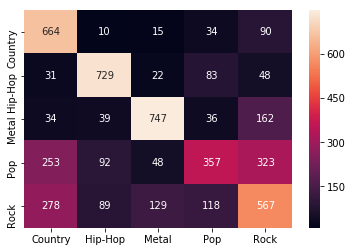

In [9]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
_ = pd.DataFrame(cm, index=genres, columns=genres)
sns.heatmap( _, annot=True, fmt='2d' )

When we created our dataset, we kept roughly an equal number of songs from each genre. Without this step, there would be much more cases of Rock songs, and the heatmap would be dominated by this row/column, attenuating all other genres.  
If this is the case, it is often helpful to display the heatmap normalized by the row or column:

          Country   Hip-Hop     Metal       Pop      Rock
Country  0.526984  0.010428  0.015609  0.054140  0.075630
Hip-Hop  0.024603  0.760167  0.022893  0.132166  0.040336
Metal    0.026984  0.040667  0.777315  0.057325  0.136134
Pop      0.200794  0.095933  0.049948  0.568471  0.271429
Rock     0.220635  0.092805  0.134235  0.187898  0.476471


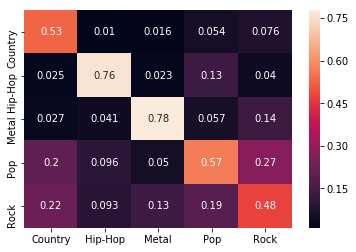

In [10]:
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm, index=genres, columns=genres)
normalized_cm = cm / cm.sum(axis=0)
print(normalized_cm)
sns.heatmap(normalized_cm, annot=True, fmt='.2g' );

          Country   Hip-Hop     Metal       Pop      Rock
Country  0.816728  0.010953  0.014735  0.031687  0.076207
Hip-Hop  0.038130  0.798467  0.021611  0.077353  0.040644
Metal    0.041820  0.042716  0.733792  0.033551  0.137172
Pop      0.311193  0.100767  0.047151  0.332712  0.273497
Rock     0.341943  0.097481  0.126719  0.109972  0.480102


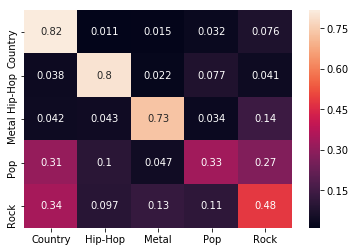

In [11]:
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm, index=genres, columns=genres)
normalized_cm = cm / cm.sum(axis=1)
print(normalized_cm)
sns.heatmap(normalized_cm, annot=True, fmt='.2g' );

### Text classification using Word Vectors
#### Average word vectors
Do the same, using a classifier that averages the word vectors of words in the document.

In [12]:
import gensim
w2v = gensim.models.Word2Vec(df.sent.str.split(), sg=1, min_count=20, size=50, window=5, workers=7)

In [13]:
def word_vec_mean(X):
    return [np.mean(list(w2v[w] for w in sent.split() if w in w2v), axis=0) for sent in X]

In [14]:
X_train_vec = np.array(word_vec_mean(X_train))
X_test_vec = np.array(word_vec_mean(X_test))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [15]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_vec, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
# Predict
print('Performance on the train set:')
y_pred = model.predict(X_train_vec)
cm = confusion_matrix(y_train, y_pred)
print( pd.DataFrame(cm, index=genres, columns=genres) )

print('\nPerformance on the test set:')
y_pred = model.predict(X_test_vec)
cm = confusion_matrix(y_test, y_pred)
print( pd.DataFrame(cm, index=genres, columns=genres) )

Performance on the train set:
         Country  Hip-Hop  Metal   Pop  Rock
Country     4532      181    238  1191  1319
Hip-Hop      148     6864    261  1078   466
Metal        173      429   6266   564   989
Pop         1263      925    641  4851  2047
Rock        1759      764   1692  2431  3906

Performance on the test set:
         Country  Hip-Hop  Metal  Pop  Rock
Country      498       16     24  135   140
Hip-Hop       12      709     41  101    50
Metal         25       51    782   53   107
Pop          139      105     68  531   230
Rock         179       96    187  280   439


In [17]:
y_pred = model.predict(X_test_vec)
print( classification_report(y_test, y_pred ))

             precision    recall  f1-score   support

    Country       0.58      0.61      0.60       813
    Hip-Hop       0.73      0.78      0.75       913
      Metal       0.71      0.77      0.74      1018
        Pop       0.48      0.49      0.49      1073
       Rock       0.45      0.37      0.41      1181

avg / total       0.58      0.59      0.59      4998



The section above raises an interesting question - have we introduced leakage by using word vectors trained on the entire dataset, including that of the test data? What do you think?

In [18]:
#averaging word vectors for all words in the text
# build a sklearn-compatible transformer 
class MeanEmbeddingVectorizer():
    def __init__(self, word2vec, num_features=300):
        self.word2vec = word2vec
        self.dim = num_features
    
    def fit(self,X,y):
        return self
  
    def transform(self, X):
        # return np.array([np.mean([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0) for words in X])
        return [np.mean(list(self.word2vec[w] for w in sent.split() if w in w2v), axis=0) for sent in X]

In [19]:
clf = LogisticRegression()
mean_vect = MeanEmbeddingVectorizer(w2v, 50)
pipe = make_pipeline(mean_vect ,clf)
pipe.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


Pipeline(memory=None,
     steps=[('meanembeddingvectorizer', <__main__.MeanEmbeddingVectorizer object at 0x0000016FDAD8B0F0>), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [20]:
y_pred = model.predict(X_test_vec)
print( classification_report(y_test, y_pred ))

             precision    recall  f1-score   support

    Country       0.58      0.61      0.60       813
    Hip-Hop       0.73      0.78      0.75       913
      Metal       0.71      0.77      0.74      1018
        Pop       0.48      0.49      0.49      1073
       Rock       0.45      0.37      0.41      1181

avg / total       0.58      0.59      0.59      4998



#### TfIdf Weighting
Do the same, using a classifier that averages the word vectors of words in the document, weighting each word by its TfIdf.


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(smooth_idf=True, sublinear_tf=False, norm=None, analyzer='word')
X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)

In [58]:
def word_vec_mean_weighted(X, X_weights,vocab):
    result = []
    for i,sent in enumerate(X):
        weight = [0]*len(w2v['the'])
        num_words = 0
        for w in sent.split():
            if w in w2v and w in vocab:
                weight += w2v[w]*X_weights[i,vocab[w]]
                num_words += 1
        if num_words>0:
            result.append(weight / num_words)
        else:
            result.append(weight)
    return np.array(result)

In [54]:
X_test_vec = word_vec_mean_weighted(X_test, X_test_tfidf, tfidf_vect.vocabulary_)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [59]:
X_train_vec = word_vec_mean_weighted(X_train, X_train_tfidf, tfidf_vect.vocabulary_)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
# X_test_vec = np.array([sum(w2v[w]*X_test_tfidf[i,tfidf_vect.vocabulary_[w]] for w in sent if w in w2v and w in tfidf_vect.vocabulary_) for i,sent in enumerate(X_test)])

In [63]:
X_train_vec.shape

(44978, 50)

In [64]:
y_train.shape

(44978,)

In [62]:
model = LogisticRegression()
model.fit(X_train_vec, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [65]:
y_pred = model.predict(X_test_vec)
print( classification_report(y_test, y_pred ))

             precision    recall  f1-score   support

    Country       0.60      0.38      0.47       813
    Hip-Hop       0.69      0.58      0.63       913
      Metal       0.64      0.76      0.70      1018
        Pop       0.40      0.55      0.46      1073
       Rock       0.36      0.32      0.34      1181

avg / total       0.53      0.52      0.51      4998



### Text classification using ConvNet
Do the same, using a ConvNet.  
The ConvNet should get as input a 2D matrix where each column is an embedding vector of a single word, and words are in order. Use zero padding so that all matrices have a similar length.  
Some songs might be very long. Trim them so you keep a maximum of 128 words (after cleaning stop words and rare words).  
Initialize the embedding layer using the word vectors that you've trained before, but allow them to change during training.  

Extra: Try training the ConvNet with 2 slight modifications:
1. freezing the the weights trained using Word2vec (preventing it from updating)
1. random initialization of the embedding layer

You are encouraged to try this question on your own.  

You might prefer to get ideas from the paper "Convolutional Neural Networks for Sentence Classification" (Kim 2014, [link](https://arxiv.org/abs/1408.5882)).

There are several implementations of the paper code in PyTorch online (see for example [this repo](https://github.com/prakashpandey9/Text-Classification-Pytorch) for a PyTorch implementation of CNN and other architectures for text classification). If you get stuck, they might provide you with a reference for your own code.

We will use code from the suggested repo above. We will create separate files for the train, validation and test datasets.  
One consideration for us is what preprocessing we want to perform.  
For example, should we remove stopwords? ConvNets have limited width, but stopwords have an effect on sentence structure that might be useful for classification. The answer isn't obvious and is best learned by experimenting.

In [ ]:
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe
import torch

In [ ]:
tokenize = lambda x: x.split()
TEXT = data.Field(sequential=True, tokenize=tokenize, lower=True, fix_length=128, batch_first=True)
LABEL = data.Field(sequential=False,use_vocab=False)

train, val, test = data.TabularDataset.splits(
        path=DIR_PATH, train='train.csv',
        validation='val.csv', test='test.csv', format='csv',
    skip_header=True,
        fields=[('lyrics_raw', TEXT), ('genre', LABEL)])

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# The input to the NN for each sonf will be a matrix od 128 lines= song words and 300 cols(features)
# this is cuttong all songs that are more than 128 words to 128
# music["128_words"]=[song[:128] if len(song)>128 else song for song in  music["letters_only"]]
#remove all emty lines
#music.drop(np.where(pd.Series([len(song) for song in  music.loc[:,"letters_only"]])==0)[0],inplace=True)
#music['128_words_vec']=[model.wv[song] for song in  music.loc[:,"128_words"]]